<a href="https://colab.research.google.com/github/ashu-vpu/DA231o_Course_Project_DataWatch/blob/main/DE_scale_spark_stream_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive to work from Google drive and Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Spark and instantiate the environment variable into the Colab host

In [2]:
#######################################
###!@0 START INIT ENVIRONMENT
!ls /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"
###!@0 END INIT ENVIRONMENT

/content/drive/MyDrive/DE_Scale_Project/SparkData/spark-3.5.2-bin-hadoop3.tgz


Create symbolic links to the area where the datasets are present to work with

In [3]:
!mkdir -p /content/data
!rm -rf /content/data/*.csv
!ln -s /content/drive/MyDrive/datasets/*.csv /content/data/

Spark initiatlisation

In [4]:
#######################################
###!@1 START OF PYSPARK INIT
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

Read the dataset, i.e. ALL cities Pollutant data csv file

In [5]:
def read_csv(path_to_file):
  return spark.read.option("delimiter", ",").csv(path_to_file, header=True, inferSchema=True)

df_All_cities_2023 = read_csv('/content/data/df_All_cities_2023.csv')

Import Spark related functions and methods

In [6]:
# prompt: import all spark related libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

In [7]:
df_All_cities_2023.printSchema()

root
 |-- City: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- PM2p5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- Ozone: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind_Speed: double (nullable = true)
 |-- Wind_Direction: double (nullable = true)
 |-- TOT-RF: double (nullable = true)
 |-- SR: double (nullable = true)
 |-- BP: double (nullable = true)
 |-- PM2p5_mean: double (nullable = true)
 |-- PM10_mean: double (nullable = true)
 |-- NO_mean: double (nullable = true)
 |-- NO2_mean: double (nullable = true)
 |-- NOx_mean: double (nullable = true)
 |-- NH3_mean: double (nullable = true)


In [8]:
# Imports

import os
import time
from pyspark.sql.functions import date_format, col
import shutil
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.feature import VectorAssembler
import threading
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
# Code for File streaming writer thread


def file_streaming_writer(stream_df):

  # Limit the tries for testing
  no_of_iter = 10
  counter = 0

  # Iterate through groups and write to files
  # Sort the DataFrame by the "year_month_date_hour" column
  sorted_stream_df = stream_df.orderBy(col("year_month_date_hour"))

  #for row in stream_df.select("year_month_date_hour").distinct().collect():
  for row in sorted_stream_df.select("year_month_date_hour").distinct().orderBy(col("year_month_date_hour")).collect():
      hour_group = row["year_month_date_hour"]
      rows = sorted_stream_df.filter(col("year_month_date_hour") == hour_group)
      file_path = os.path.join(streaming_staging_dir, f"data_{hour_group}")
      rows.coalesce(1).write.csv(file_path, header=True, mode="overwrite") # mode="overwrite" to avoid errors on re-runs

      # Copy the cvs files alone into streaming input path
      for root, dirs, files in os.walk(file_path):
        #print(f"root: {root}, dirs: {dirs}, files: {files}")
        for file in files:
          if file.startswith("part-"):
            # Get the current timestamp in the desired format
            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            #print(f"copy file {root}/{file} to {streaming_input_dir}/data_{timestamp}.csv")
            shutil.copy(
              os.path.join(root, file),
              os.path.join(streaming_input_dir, f"data-{timestamp}.csv")
            )
      #Delete the temporary directory
      if os.path.isdir(file_path):
        shutil.rmtree(file_path)  # Delete the directory
      #print(f"Written new file: data_{hour_group}.csv")
      if counter >= no_of_iter:
        break
      counter += 1
      time.sleep(5)  # Simulate write delay



In [10]:
# Code for thread handling Spark Streaming.

def process_streaming_data(loaded_model):

    input_directory= streaming_input_dir
    schema=df_All_cities_2023.schema
    output_path= streaming_output_dir
    checkpoint_path=streaming_checkpoint_dir
    timeout=60

    # Read streaming data
    csv_stream = spark.readStream \
        .schema(schema) \
        .option("header", "true") \
        .option("maxFilesPerTrigger", 1) \
        .csv(input_directory)

    # Prepare features for prediction
    assembler = VectorAssembler(
        inputCols=['PM2p5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone'],
        outputCol='features'
    )
    csv_stream_assembled = assembler.transform(csv_stream)

    # Make predictions
    result_prediction = loaded_model.transform(csv_stream_assembled)
    result_prediction = result_prediction.withColumnRenamed("prediction", "pred_AQI")

    # Define a UDF to classify AQI levels
    def pred_AQI_class(x):
        if x <= 50:
            return "Good"
        elif x <= 100:
            return "Satisfactory"
        elif x <= 200:
            return "Moderate"
        elif x <= 300:
            return "Poor"
        elif x <= 400:
            return "Very Poor"
        elif x > 400:
            return "Severe"
        else:
            return None

    AQI_class_udf = udf(pred_AQI_class, StringType())
    result_prediction = result_prediction.withColumn("pred_AQI_class", AQI_class_udf("pred_AQI"))

    # Select relevant columns
    result_df = result_prediction.select("City", "Timestamp", "pred_AQI", "pred_AQI_class")

    # Write the output stream
    query = result_df \
        .writeStream \
        .format("csv") \
        .option("path", output_path) \
        .option("header", "true") \
        .option("checkpointLocation", checkpoint_path) \
        .outputMode("append") \
        .option("truncate", "false") \
        .start()

    # Wait for the stream to finish
    query.awaitTermination(timeout=timeout)

In [11]:
# Code for thread3 where we simulate an application consuming the output data from spark streaming to provide enduser update.

# Function to assign color based on the AQI value
def get_color(aqi):
    if aqi <= 50:
        return 'green'  # Good
    elif aqi <= 100:
        return 'yellow'  # Satisfactory
    elif aqi <= 200:
        return 'orange'  # Moderate
    elif aqi <= 300:
        return 'red'  # Poor
    elif aqi <= 400:
        return 'purple'  # Very Poor
    else:
        return 'maroon'  # Severe

def monitor_directory():

    # Keep track of files already processed
    processed_files = set()

    while True:
        try:
            # List all CSV files in the directory
            files = [f for f in os.listdir(streaming_output_dir) if f.endswith('.csv')]
            # Sort files by creation time
            #files.sort(key=lambda f: os.path.getctime(f))
            #print(files)

            # Process new files
            for file_name in files:
                if file_name not in processed_files:
                    file_path = os.path.join(streaming_output_dir, file_name)
                    try:
                        # Read the CSV file into a Pandas DataFrame
                        print(f"\nNew file detected: {file_name}")
                        df = pd.read_csv(file_path)

                        # Ensure the required columns exist
                        if 'City' in df.columns and 'pred_AQI' in df.columns:

                            #print(f"Generating bar plot for {file_name}...")

                            #timestamp = df['Timestamp'].strftime("%Y%m%d%H")
                            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
                            first_timestamp = df['Timestamp'].iloc[0]
                            date_str = first_timestamp.strftime("%Y-%m-%d")
                            hour = first_timestamp.hour
                            timestamp = f"Date: {date_str} Hour: {hour}"

                            # Assign colors based on pred_AQI values
                            colors = df['pred_AQI'].apply(get_color)
                            # Create a bar plot
                            plt.figure(figsize=(10, 6))
                            plt.bar(df['City'], df['pred_AQI'], color=colors)
                            plt.xlabel("City")
                            plt.ylabel("pred_AQI")
                            plt.title(f"AQI Values by City for: ({timestamp})")
                            plt.xticks(rotation=45, ha='right')
                            plt.tight_layout()

                            # Show the plot
                            plt.show()
                        else:
                            print(f"File {file_name} does not contain 'City' and 'Aqi' columns.")

                    except Exception as e:
                        print(f"Error reading {file_name}: {e}")
                    # Mark file as processed
                    processed_files.add(file_name)
                    print(f"\nProcessed file: {file_name}")

            # Wait for a short interval before checking again
            time.sleep(1)
        except Exception as e:
            print(f"Error monitoring directory: {e}")
            break




New file detected: part-00000-bb2a7f40-6029-448d-aeea-46b6d71f40f6-c000.csv


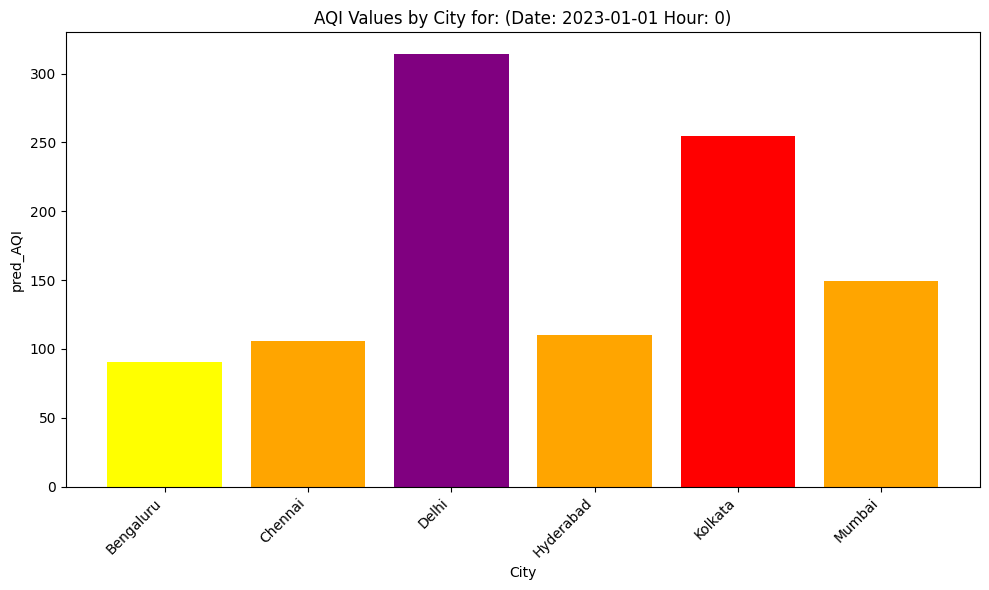


Processed file: part-00000-bb2a7f40-6029-448d-aeea-46b6d71f40f6-c000.csv

New file detected: part-00000-353a30e2-a395-4332-9f9e-b99041985e09-c000.csv
Error reading part-00000-353a30e2-a395-4332-9f9e-b99041985e09-c000.csv: No columns to parse from file

Processed file: part-00000-353a30e2-a395-4332-9f9e-b99041985e09-c000.csv

New file detected: part-00000-1fccfff0-4a91-4f09-aef6-084760948fd7-c000.csv
Error reading part-00000-1fccfff0-4a91-4f09-aef6-084760948fd7-c000.csv: No columns to parse from file

Processed file: part-00000-1fccfff0-4a91-4f09-aef6-084760948fd7-c000.csv

New file detected: part-00000-fc434ea3-401d-4090-8fbf-87e466aa492c-c000.csv


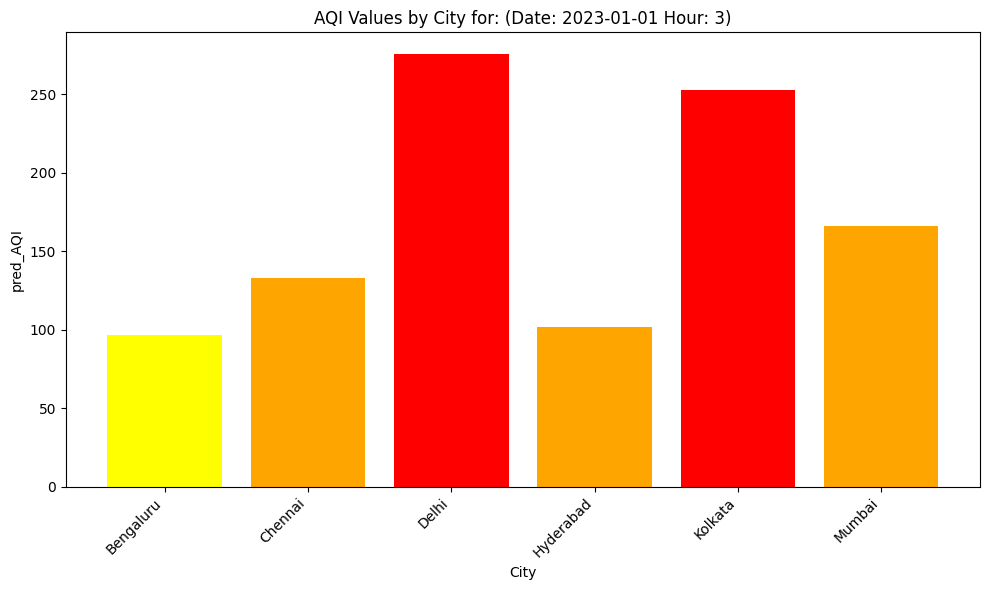


Processed file: part-00000-fc434ea3-401d-4090-8fbf-87e466aa492c-c000.csv

New file detected: part-00000-a0c7f88f-6d76-4b5b-a096-7b7e206ba883-c000.csv


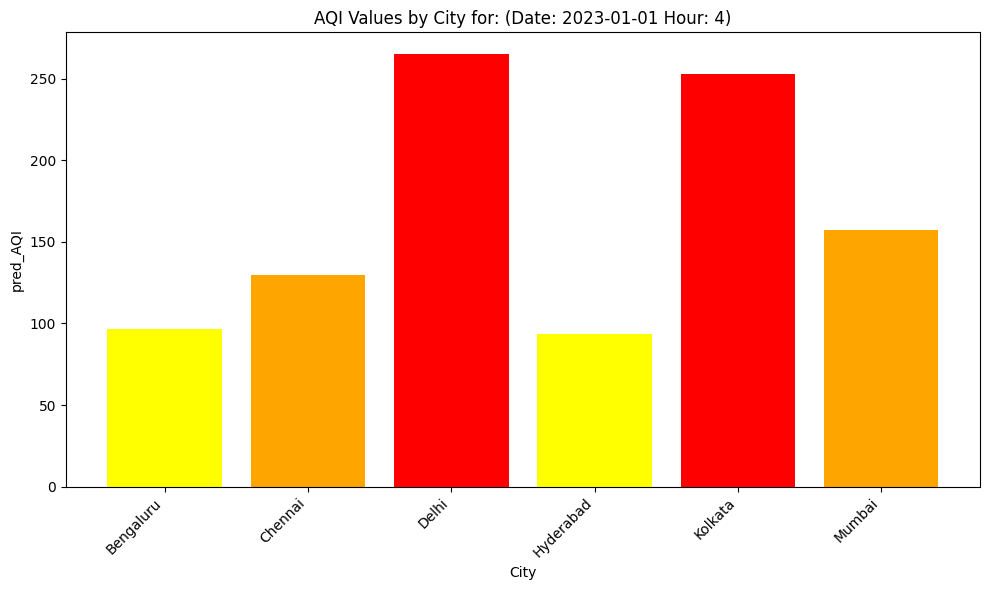


Processed file: part-00000-a0c7f88f-6d76-4b5b-a096-7b7e206ba883-c000.csv

New file detected: part-00000-0c505d92-9c57-49c1-b09f-3a827eedec5a-c000.csv


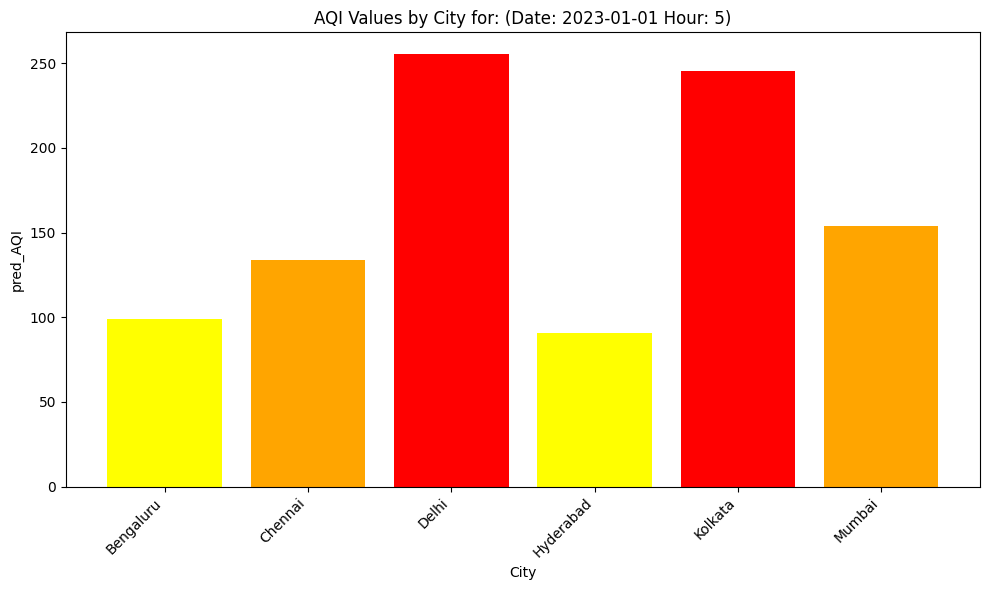


Processed file: part-00000-0c505d92-9c57-49c1-b09f-3a827eedec5a-c000.csv

New file detected: part-00000-030f20cf-b456-48bd-877e-8d5dee611d83-c000.csv


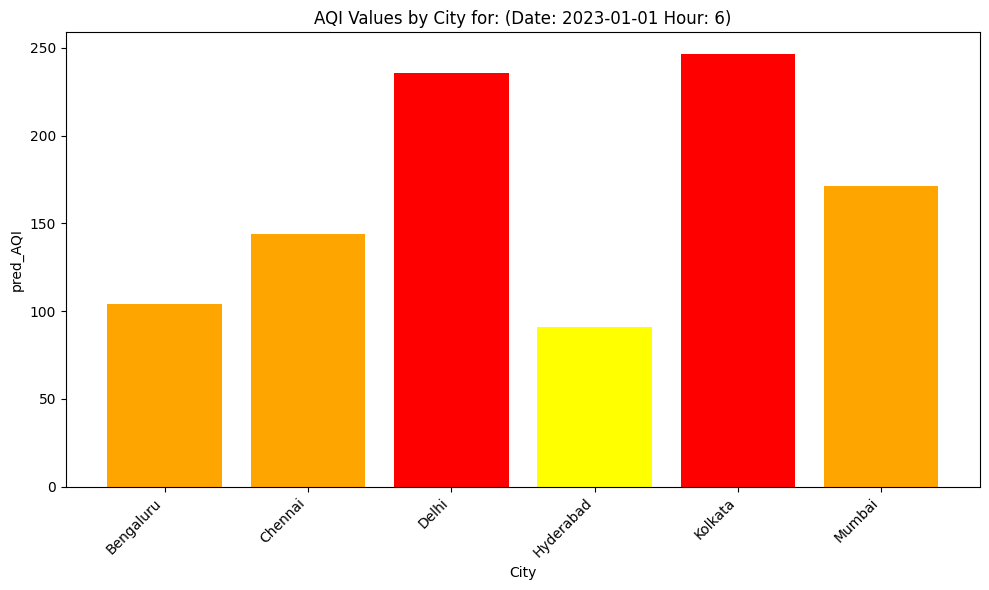


Processed file: part-00000-030f20cf-b456-48bd-877e-8d5dee611d83-c000.csv

New file detected: part-00000-d40ec017-7f08-4e40-9d57-0a8e8e822b52-c000.csv
Error reading part-00000-d40ec017-7f08-4e40-9d57-0a8e8e822b52-c000.csv: No columns to parse from file

Processed file: part-00000-d40ec017-7f08-4e40-9d57-0a8e8e822b52-c000.csv

New file detected: part-00000-0be9df1e-4bc4-4384-8c9e-b37fbf6c1fa1-c000.csv
Error reading part-00000-0be9df1e-4bc4-4384-8c9e-b37fbf6c1fa1-c000.csv: No columns to parse from file

Processed file: part-00000-0be9df1e-4bc4-4384-8c9e-b37fbf6c1fa1-c000.csv

New file detected: part-00000-81b82681-22b6-491c-9176-0a65526387b3-c000.csv


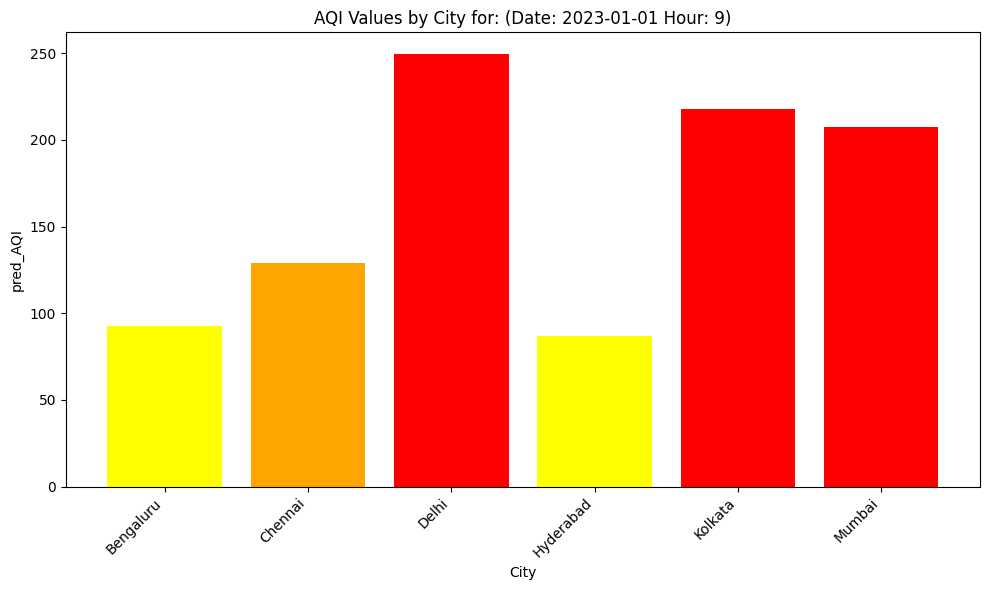


Processed file: part-00000-81b82681-22b6-491c-9176-0a65526387b3-c000.csv

New file detected: part-00000-6424a3ca-6a69-40df-bb42-4cb07c57f88c-c000.csv


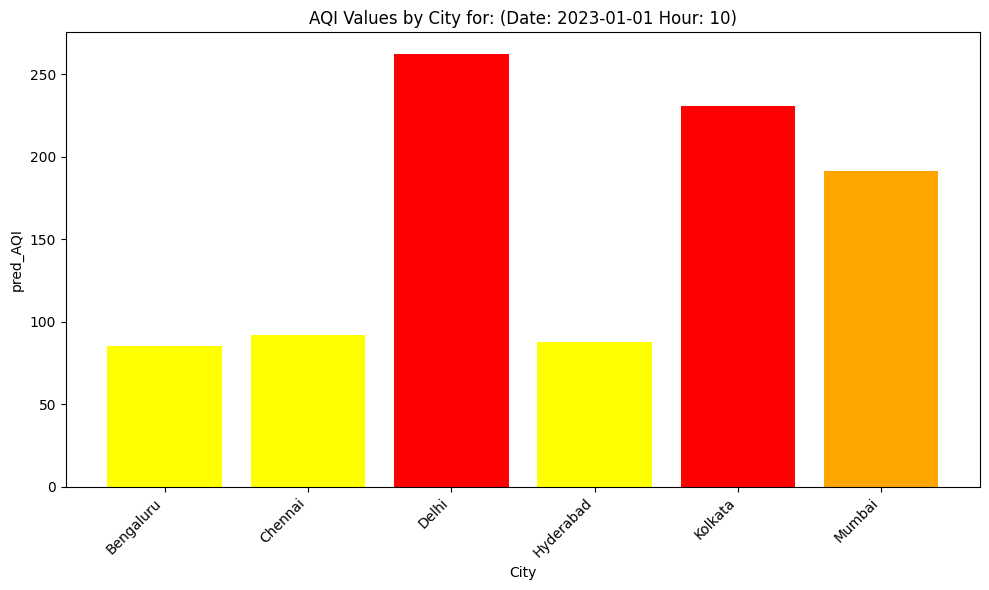


Processed file: part-00000-6424a3ca-6a69-40df-bb42-4cb07c57f88c-c000.csv


In [12]:
# Driver Code

# Main function to run both threads
def main(pollutant_data_2023):
    # Thread 1: File streaming writer
    file_writer_thread = threading.Thread(target=file_streaming_writer, args=(pollutant_data_2023,), daemon=True)

    # Load the pre-trained model
    model_path="/content/drive/MyDrive/DE_Scale_Project/best_rf_model"
    saved_model = RandomForestRegressionModel.load(model_path)
    # Thread 2: Spark streaming consumer
    spark_consumer_thread = threading.Thread(target=process_streaming_data, args=(saved_model,), daemon=True)

    #Thread3: Monitor directory
    monitor_directory_thread = threading.Thread(target=monitor_directory, daemon=True)

    # Start threads
    file_writer_thread.start()
    spark_consumer_thread.start()
    monitor_directory_thread.start()

    # Wait for both threads to complete
    file_writer_thread.join(timeout=120)
    spark_consumer_thread.join(timeout=120)
    monitor_directory_thread.join(timeout=120)

if __name__ == "__main__":

  # Prepare data: Extract year, month, day, and hour
  df_All_cities_2023 = df_All_cities_2023.withColumn(
      "year_month_date_hour", date_format(col("Timestamp"), "yyyy-MM-dd-HH")
  )

  streaming_input_dir = "/content/streaming_input_dir"
  # Delete if this already exists
  if os.path.isdir(streaming_input_dir):
    shutil.rmtree(streaming_input_dir)  # Delete the directory
  os.makedirs(streaming_input_dir, exist_ok=True)

  streaming_staging_dir = "/content/streaming_staging_data"
  os.makedirs(streaming_staging_dir, exist_ok=True)

  streaming_output_dir = "/content/streaming_output_data"
  #streaming_output_dir = "/content/drive/MyDrive/DE_Scale_Project/Datasets/All_cities/streaming_input_tony"
  # Delete if this already exists
  if os.path.isdir(streaming_output_dir):
    shutil.rmtree(streaming_output_dir)  # Delete the directory
  os.makedirs(streaming_output_dir, exist_ok=True)

  streaming_checkpoint_dir = "/content/checkpoint/"
  # Delete if this already exists
  if os.path.isdir(streaming_checkpoint_dir):
    shutil.rmtree(streaming_checkpoint_dir)  # Delete the directory
  os.makedirs(streaming_checkpoint_dir, exist_ok=True)

  main(df_All_cities_2023)


